In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures, SplineTransformer, KBinsDiscretizer, \
     StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, r_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, get_scorer_names, accuracy_score, f1_score, precision_score, \
     confusion_matrix, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import os
import pickle
import wandb
import warnings
import utility as ut
warnings.filterwarnings('ignore')

In [83]:
run = wandb.init(
  project=ut.PROJECT_NAME, entity=ut.ENTITY, job_type="modeling",
  notes="Modeling without hyperparameter tuning",
  tags=["baseline", "multiclass_classification", "imbalanced_data", "random_forest", "v2"]
)

In [84]:
train = pd.read_csv('../Inputs/ball-by-ball prediction/train.csv')

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276285 entries, 0 to 276284
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   venue                276285 non-null  object 
 1   innings              276285 non-null  int64  
 2   batting_team         276285 non-null  object 
 3   bowling_team         276285 non-null  object 
 4   striker              276285 non-null  object 
 5   non_striker          276285 non-null  object 
 6   bowler               276285 non-null  object 
 7   overs                276285 non-null  int64  
 8   balls                276285 non-null  int64  
 9   bat_0_runs           276285 non-null  float64
 10  bat_1_runs           276285 non-null  float64
 11  bat_2_runs           276285 non-null  float64
 12  bat_3_runs           276285 non-null  float64
 13  bat_4_runs           276285 non-null  float64
 14  bat_6_runs           276285 non-null  float64
 15  bat_num_dismissal

In [88]:
def safe_div(x,y):
    if y == 0:
        return 0
    return x.div(y, axis=0)

In [89]:
class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Batting features
        X['bat_runs_scored'] = 1*X['bat_1_runs']+2*X['bat_2_runs']+3*X['bat_3_runs']+4*X['bat_4_runs']+6*X['bat_6_runs']
        # X['bat_strike_rate'] = safe_div(X['bat_runs_scored'], X['bat_total_balls'])*100
        # X['bat_avg'] = safe_div(X['bat_runs_scored'], X['bat_num_dismissals'])

        # Bowling features
        X['bowl_runs_conceded'] = 1*X['bowl_1_runs']+2*X['bowl_2_runs']+3*X['bowl_3_runs']+4*X['bowl_4_runs']+6*X['bowl_6_runs']
        # X['bowl_average'] = safe_div(X['bowl_runs_conceded'], X['bowl_total_balls'])
        # X['bowl_strike_rate'] = safe_div(X['bowl_total_balls'], X['bowl_num_dismissals'])
        # Other features
        # ... (include any other feature engineering steps here)

        return X

In [90]:
minitrain = train.copy()

In [91]:
le = LabelEncoder()
X, y = minitrain.drop('target', axis=1), le.fit_transform(minitrain['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=420)

In [92]:
cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(exclude=['object']).columns

In [93]:
cat_features

Index(['venue', 'batting_team', 'bowling_team', 'striker', 'non_striker',
       'bowler'],
      dtype='object')

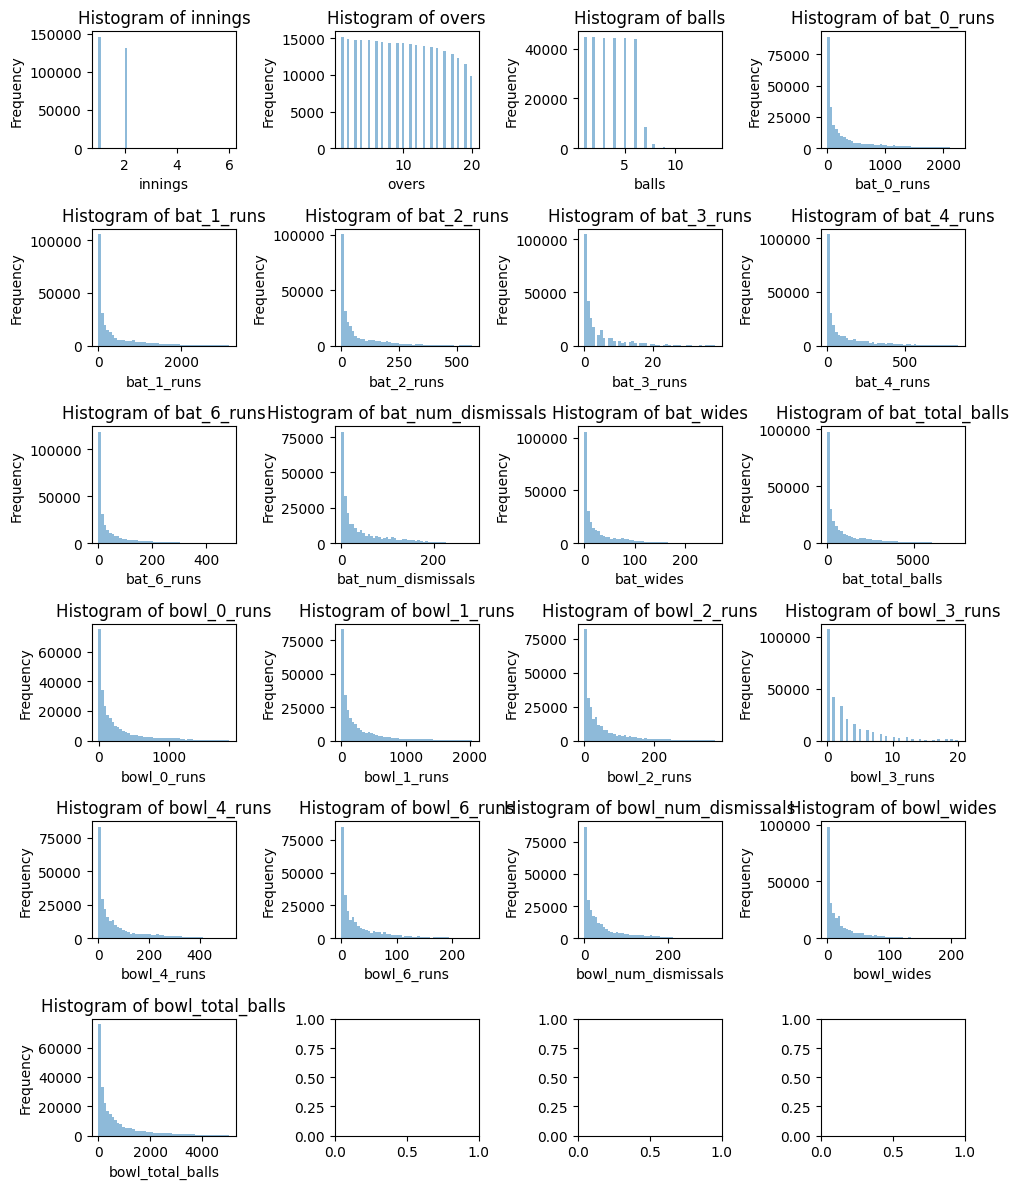

In [94]:
# Get the number of columns in the dataframe
ncols = X.shape[1]

# Set the number of rows in the subplot
nrows = int(np.ceil(ncols / 5))

# Create the subplot
fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(10, nrows*2))
ax = ax.ravel()

# Loop through each column in the dataframe
for i, col in enumerate(num_features):
    ax[i].hist(X[col], bins=50, alpha=0.5)
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Frequency")
    ax[i].set_title("Histogram of " + col)

plt.tight_layout()
plt.show()

In [95]:
numeric_transformer = Pipeline([
      # ('poly_feats', PolynomialFeatures(degree=2)),
      # ('log_feats', LogTransformer()),
      # ('b_splines', SplineTransformer()),
      ('scaler', StandardScaler()),
      # ('bin', KBinsDiscretizer(encode='ordinal')), #only improved Lars
      # ('select_feats', SelectKBest(f_regression, k='all'))
])
categorical_transformer = Pipeline([
      ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

In [96]:
preprocessor = ColumnTransformer(
    transformers=[
        ('new_feats', CustomFeatureTransformer(), num_features),
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

In [97]:
# cw = {}
# classifier = SVC(kernel='rbf', class_weight='balanced', random_state=3142)
classifier = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced', n_jobs=-1, random_state=3142)
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor)
    ,('classifier',classifier)
])

In [98]:
model = pipeline.fit(X_train, y_train)

In [99]:
model.score(X_train, y_train)

0.5519834630976128

In [100]:
predictions = model.predict(X_test)

In [101]:
wandb.summary['accuracy_test'] = accuracy_score(y_test, predictions)
wandb.summary['f1_score_test'] = f1_score(y_test, predictions, average='weighted')
wandb.summary['precision_test'] = precision_score(y_test, predictions, average='weighted')
wandb.summary['recall_test'] = recall_score(y_test, predictions, average='weighted')

In [102]:
train_preds = model.predict(X_train)

In [103]:
wandb.summary['accuracy_train'] = accuracy_score(y_train, train_preds)
wandb.summary['f1_score_train'] = f1_score(y_train, train_preds, average='weighted')
wandb.summary['precision_train'] = precision_score(y_train, train_preds, average='weighted')
wandb.summary['recall_train'] = recall_score(y_train, train_preds, average='weighted')

In [104]:
labels = le.classes_
labels

array(['0_runs', '1_runs', '2_runs', '3_runs', '4_runs', '6_runs',
       'Wicket'], dtype=object)

In [106]:
# Visualize single plot
wandb.sklearn.plot_confusion_matrix(y_test, predictions, labels)
wandb.sklearn.plot_roc(y_test, model.predict_proba(X_test), labels)
wandb.sklearn.plot_precision_recall(y_test, model.predict_proba(X_test), labels)
wandb.sklearn.plot_class_proportions(y_train, y_test, labels)
# wandb.sklearn.plot_feature_importances(model.named_steps['classifier'], X_train.columns, max_num_features=10)

wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.


In [107]:
wandb.finish()

accuracy_test,0.30823
accuracy_train,0.55198
f1_score_test,0.32844
f1_score_train,0.55905
precision_test,0.36129
precision_train,0.60213
recall_test,0.30823
recall_train,0.55198


In [80]:
cm = confusion_matrix(y_test, predictions)

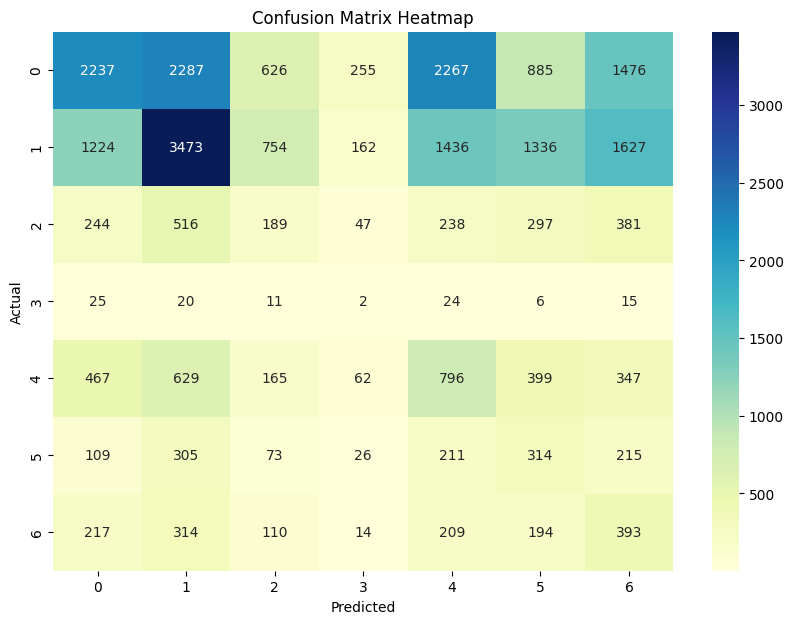

In [81]:
# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
pd.DataFrame(y_test).value_counts()

0    10033
1    10012
4     2865
2     1912
6     1451
5     1253
3      103
dtype: int64

In [ ]:
pd.DataFrame(predictions).value_counts()

0    12134
1     8463
4     3032
2     2036
5     1312
6      597
3       55
dtype: int64

In [ ]:
print(f'----{type(classifier).__name__}-----')
print (f'Model f1 score (macro):{f1_score(predictions, y_test, average="macro")}')
print (f'Model f1 score (micro):{f1_score(predictions, y_test, average="micro")}')
print (f'Model f1 score (weighted):{f1_score(predictions, y_test, average="weighted")}')
# print (f'Model acc:{accuracy_score(predictions, y_test)}')

----LogisticRegressionCV-----
Model f1 score (macro):0.1674036246848558
Model f1 score (micro):0.3377972420283036
Model f1 score (weighted):0.3438043124369311


In [141]:
# cv = KFold(2, shuffle=False)
# regressors = [lm.ElasticNetCV(l1_ratio = params['enet_l1_ratio'], alphas=params['enet_alphas'], cv = cv.split(X_train),max_iter=100, n_jobs=-1),
#             #   lm.LassoCV(alphas = params['lasso_alphas'], cv = cv.split(X_train), max_iter=100, n_jobs=-1),
#             #   lm.LinearRegression(n_jobs=-1), lm.RidgeCV(alphas=params['ridge_alphas'], cv = cv.split(X_train)),
#             #   lm.LarsCV(max_iter=100,normalize=False, cv = cv.split(X_train), n_jobs=-1)
#               ]
# model_dict = {}
# for regressor in regressors:
#     pipeline = Pipeline(steps = [
#                ('preprocessor', preprocessor)
#               ,('regressor',regressor)
#            ])
#     model = pipeline.fit(X_train, y_train)
#     predictions = model.predict(X_train)
#     model_dict[type(regressor).__name__] = model
#     print(f'----{type(regressor).__name__}-----')
#     print (f'Model r2 score:{r2_score(predictions, y_train)}')
#     print (f'Model MAE:{mean_absolute_error(predictions, y_train)}')